## Task 1: Neural networks

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [71]:
# load cifar10 dataset
def load_data():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()
    # normalise the values
    x_train = x_train.astype('float32') / 255
    x_val = x_val.astype('float32') / 255

    # convert labels to categoical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
    return ((x_train, y_train), (x_val, y_val))

(x_train, y_train), (x_test, y_test) = load_data()

### 1.1 Multi-layer perceptron
### 1.1.1
We implement an MLP classification model in numpy. The model will have five hidden layers, each with 400 neurons. The activation function between all hidden layers is tanh. The final output layer will have 10 neurons with a separate softmax activation function acting on the final output of the network. This would give us the probability of the data point belonging to each of the 10 classes. The data point will be classified to the class giving the highest probability.

In [3]:
print(x_train[0].shape)
print(x_test[0].shape)
print(x_train.shape)
print(y_train[0])

(32, 32, 3)
(32, 32, 3)
(50000, 32, 32, 3)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


By inspecting the shape of each data point(image) in the data set, each image has dimensions of 32 by 32 pixels. Since the image is coloured, it has 3 colour channels. The total number of input values is thus $32 * 32 * 3 = 3072 $.

The MLP network will require the following parameters:

Input Layer -> First Hidden Layer:
* Kernel $\boldsymbol{W}^{(0)} \in\mathbb{R}^{3072\times 400}$
* Bias $\boldsymbol{b}^{(0)} \in\mathbb{R}^{400}$

ith Hidden Layer -> (i + 1) th Hidden Layer:
* Kernel $\boldsymbol{W}^{(i)} \in\mathbb{R}^{400\times 400}$, $i=1, 2, 3, 4$
* Bias $\boldsymbol{b}^{(i)} \in\mathbb{R}^{400}$,  $i=1, 2, 3, 4$

Fifth Hidden Layer -> Output Layer:
* Kernel $\boldsymbol{W}^{(5)} \in\mathbb{R}^{400\times 10}$
* Bias $\boldsymbol{b}^{(5)} \in\mathbb{R}^{10}$


We will create these parameters as numpy arrays, and initialise the kernel values with samples from a zero-mean Gaussian distribution with variance $2 / (n_{in} + n_{out})$, where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layer respectively. This initialisation strategy is known as [Glorot initialisation](http://proceedings.mlr.press/v9/glorot10a.html). The bias parameters will be initialised to zeros. The function below does the following.

In [4]:
def init_params_per_layer(n_in, n_out):
    variance = 2. / (n_in + n_out)
    W = np.random.randn(n_in, n_out) * np.sqrt(variance)
    b = np.zeros(n_out)
    return W, b


All the layers in the MLP network are represented as objects that are instantiated from the classes defined below.

Each layer has 3 main functions, forward, backward and update_params. 

The forward function is called during the forward pass and performs either an affine transformation or applies an activation function to the input. During the forward pass, the inputs to the layer is stored to be used to calculate the gradients during backpropagation. The backward function is called during backpropagation to calculate the gradients with respect to the weight and bias parameters. This function returns $\frac{\delta \mathcal{L}}{\delta \mathcal{z}}$, where $\mathcal{z}$ is the output of each layer. This gradient is then further propagated backwards to the lower layers of the network. The update params function is called at each step of the gradient descent algorithm.

At each neuron, we can write the affine transformation as:
$$
    Z = XW + B
$$
and the activation function as
$$
 A = g(Z)
$$
where Z is the pre activation output, $XW$ is the output of the previous layer, W is the weight parameters, B is the bias parameters, A is the post activation output and g is the activation function.

The parameters of each layer, W and b can be updated using gradient descent, using
$$
W = W - \alpha \frac{\delta L}{\delta W}
\\
b = b - \alpha \frac{\delta L}{\delta b}
$$
where $\alpha$ is the learning rate, and $L$ is the loss value.

To calculate the gradient of loss with respect to the parameters, we can use the chain rule. Through backpropagation, we assume that we will receive $\frac{\delta L}{\delta Z}$, and we can calculate:

$$
\frac{\delta L}{\delta W} = \frac{\delta L}{\delta Z} \cdot \frac{\delta Z}{\delta W} 
\\ 

\frac{\delta L}{\delta b} = \frac{\delta L}{\delta Z} \cdot \frac{\delta Z}{\delta b} 
$$
To pass the gradient on to the lower layer, we also calculate: 

$$
\frac{\delta L}{\delta X} = \frac{\delta L}{\delta Z} \cdot \frac{\delta Z}{\delta X} 
$$

These values can be calculated using the formulas:

$$
\frac{\delta L}{\delta X} = \frac{\delta L}{\delta Z} W^T
\\
\frac{\delta L}{\delta W} = X^T \frac{\delta L}{\delta Z}
\\
\frac{\delta L}{\delta W} = 1^T \frac{\delta L}{\delta Z}
$$

Since there are no parameters for the activation layer, we only need to pass $\frac{\delta L}{\delta Z}$ back to the previous layers to cater to backpropagation. This is given by:
$$
\frac{\delta L}{\delta Z} = \frac{\delta L}{\delta A} \circ g'(Z)
$$

where g' is the derivative of the activation function, applied element-wise to the inputs, and $\frac{\delta L}{\delta A}$ is given to us by backpropagation. The $\circ$ indicates that this is an element wise multiplication function.

The building block of the model is the dense (or fully-connected) layer. The following class, DenseLayer, implements the affine transformation of this layer, given kernel and bias parameters and the input to the layer.

In [5]:
class DenseLayer():
    """
    Dense layer is a fully connected layer that performs affine transformation of input
    """

    def __init__(self, n_in, n_out):
        self.n_in = n_in
        self.n_out = n_out
        
        self.W, self.b = init_params_per_layer(n_in, n_out)

        self.current_input = None
        self.grad_W = None
        self.grad_b = None

    def forward(self, x):
        # x: K x h_in array of inputs
        # W: h_in x h_out array for kernel matrix parameters
        # b: Length h_out 1-D array for bias parameters
        # returns: K x h_out output array 
        
        self.current_input = x
        h = x @ self.W + self.b
        return h
    
    def backward(self, grad_z):
        """
        grad_z -- gradient array with shape (batch_size, n_out)
        """
        self.grad_W = self.current_input.T @ grad_z
        onesT = np.ones((1, grad_z.shape[0]))
        self.grad_b = onesT @ grad_z

        return grad_z @ self.W.T
    
    def update_params(self, learning_rate):
        self.W = self.W - learning_rate * self.grad_W
        self.b = self.b - learning_rate * self.grad_b
    
    def __call__(self, x):
        return self.forward(x)


The following classes defines both the Flatten layer that is used to flatten all the inputs of each 2D image, and the Tanh activation layer.

In [6]:
class FlattenLayer():
    def forward(self, x):
        x_reshaped = np.array([x_i.reshape(3072) for x_i in x])
        return x_reshaped
    def backward(self, grad_z):
        pass
    def update_params(self, lr):
        pass
    def __call__(self, x):
        return self.forward(x)


class TanhLayer():
    """
        Defines Tanh activation layer
    """
    def __init__(self):
        self.current_input = None

    def forward(self, x):
        self.current_input = x
        output = np.tanh(x)
        return output
    
    def backward(self, grad_z):
        res = np.tanh(self.current_input) ** 2
        grad_tanh = 1 - res
        return grad_z * grad_tanh
    
    def update_params(self, learning_rate):
        pass

    def __call__(self, x):
        return self.forward(x)


Now, we create our MLP network by linking dense layers and activation layers together to form our final neural network model.

In [8]:
class MultiLayerPerceptron():
    def __init__(self):
        
        self.layers = []
        num_of_hidden_layers = 4
        # first flatten the 2d image inputs into a 1d vector
        flatten_layer = FlattenLayer()
        self.layers.append(flatten_layer)

        # add the first hidden layer to the model
        first_layer = DenseLayer(3072, 400)
        self.layers.extend((first_layer, TanhLayer()))
        
        # add a hidden layer and an activation layer to the model 
        for i in range(num_of_hidden_layers):

            layer = DenseLayer(400, 400)
            self.layers.extend((layer, TanhLayer()))

        last_layer = DenseLayer(400, 10)
        self.layers.append(last_layer)
    def forward(self, x):
        output = x

        for layer in self.layers:
            # print(f"output shape: {output.shape}")
            output = layer(output)
        return output
    
    def backward(self, grad_z):
        
        output_loss_grad = grad_z
        
        for layer in reversed(self.layers):
            output_loss_grad = layer.backward(output_loss_grad)
        
        return output_loss_grad
    
    def update_params(self, learning_rate):
        
        for layer in self.layers:
            layer.update_params(learning_rate)
    
    def __call__(self, x):
        return self.forward(x)



Before we start training our model, we want to determine the loss function that we use to optimise the parameters of our MLP during SGD. Similarly, the loss function is treated as a layer object.
Since this is a classification task, the loss function is given by cross entropy loss, with equation:

$$
\hat{y_i} = \text{softmax}(z_i), \enspace \text{softmax}(z_{i, c}) = \frac{e^{z_{i, c}}}{\sum_{k}e ^{z_{i, k}}}
$$
$$
\mathcal{L} := - \frac{1}{N}\sum_{i=1}^{N}\sum_{c=1}^{C} y_{i, c}\mathcal{log}(\hat{y_{i, c}})

$$

where $\hat{y_i}$ is a vector of predicted probabilities of the data point i belonging to the 10 classes, $\hat{y}$ is the matrix consisting of the full batch of vectors $\hat{y_i}$, $\mathcal{y}$ is the matrix with each vector representing the one hot encoded version of the actual label of the data point, $C$ is the total number of classes, $N$ is the batch size.

To update the parameters of our model, we also need to calculate the gradient of the loss with respect to the output of our model. This can be calculated using the combined joint derivative of softmax and cross-entropy loss, which is given by:
$$
\frac{\delta \mathcal{L}}{\delta \mathcal{z}} = \frac{1}{N} (\hat{y} - y) 
$$


In [9]:
def softmax(x):
    # x: K * 10 array of inputs
    # returns K * 10 array of outputs
    numerator = np.exp(x)
    denominator = np.sum(numerator, axis=1)
    # calculate softmax vector for each batch x
    probs = np.array([numer / denom for numer, denom in zip(numerator, denominator)])
    return probs

class CrossEntropyLossLayer():
    def __init__(self):
        self.cache = None

    def forward(self, y_pred, y_actual):
        # calculate value of loss function
        assert(len(y_actual) == len(y_pred))
        batch_size = len(y_pred)
        probs = softmax(y_pred)
        self.cache = y_actual, probs

        sum_for_each_class = np.sum(y_actual * np.log(probs), axis=1)
        return - 1 / batch_size * np.sum(sum_for_each_class)

    def backward(self):
        # compute derivative of loss with respect to predicted outputs, y
        y_target, probs = self.cache

        batch_size = len(y_target)
        return 1 / batch_size * (probs - y_target)

    def __call__(self, x):
        return self.forward(x)



Now, we can start to train our model by defining a trainer class that takes in different hyperparameters for the model and trains the network.

In [13]:
import math
import time
class Trainer():
    def __init__(self, network, batch_size, no_epochs, learning_rate, loss_layer):
        self.network = network
        self.batch_size = batch_size
        self.no_epochs = no_epochs
        self.learning_rate = learning_rate
        self.loss_layer  = loss_layer
    
    def shuffle(self, train_X, train_y):
        shuffled_indx = np.random.permutation(np.arange(len(train_X)))
        shuffled_x = train_X[shuffled_indx]
        shuffled_y = train_y[shuffled_indx]
        return shuffled_x, shuffled_y
    
    def evaluate(self, y_pred, y_train):
        return (y_pred == y_train).mean()

    def train(self, train_X, train_y, test_X, test_y, log_time=False):
        """
            Performs the following steps for no_epoch times:
            - Shuffles input data
            - Split dataset into batches of size 'batch_size'
            - For each batch:
                - performs forward pass through the network
                - compute the cross-entropy loss
                - Performs backward pass to compute gradients of loss wrt params
                - update the params
        """
        loss_train_history = []
        accuracy_train_history = []
        loss_test_history = []
        accuracy_test_history = []

        start = time.time()

        for i in range(self.no_epochs):
            # shuffle dataset
            shuffled_X, shuffled_y = self.shuffle(train_X, train_y)

            bc = 0
            preds = np.array([])
            N = shuffled_X.shape[0]

            while bc < N:
                # get batch
                end_index = min(bc + self.batch_size, N)
                batch_X, batch_y = shuffled_X[bc : end_index], shuffled_y[bc : end_index]

                # perform forward pass
                batch_predicted = self.network.forward(batch_X)


                # compute loss and gradient
                loss = self.loss_layer.forward(batch_predicted, batch_y)
                loss_grad = self.loss_layer.backward()
                # print("loss_grad shape: ", loss_grad.shape)
                # record loss for every epoch
                if math.isnan(loss):
                    print(f"math is nan epoch: {i},  bc = {bc / 128}")
                    break
              
                # perform backward pass
                grad = self.network.backward(loss_grad)

                # update parameters
                self.network.update_params(self.learning_rate)

                bc += self.batch_size
            
            # predict classes for training dataset
            preds_trng = self.network(shuffled_X)
            # predict which class each data point is classified into
            preds_trng_labels = softmax(preds_trng).argmax(axis=1).squeeze()
            # evaluate accuracy of the training dataset
            labels_train_y = shuffled_y.argmax(axis=1).squeeze()
            # calculate loss
            loss_trng = self.loss_layer.forward(preds_trng, shuffled_y)
            loss_train_history.append(loss_trng)
            print(f"Training Loss for Epoch {i + 1} is {loss_trng}")

            accuracy = self.evaluate(preds_trng_labels, labels_train_y)
            accuracy_train_history.append(accuracy)
            print(f"Training Accuracy for Epoch {i + 1} is {accuracy}")
            
            # predict classes for the test dataset
            preds_test = self.network(test_X)
            preds_labels = softmax(preds_test).argmax(axis=1).squeeze()
            y_labels = test_y.argmax(axis=1).squeeze()
            # evaluate loss value of network on test dataset
            loss_test = self.loss_layer.forward(preds_test, test_y)
            loss_test_history.append(loss_test)
            # evaluate accuracy of test dataset
            accuracy_test = self.evaluate(preds_labels, y_labels)
            accuracy_test_history.append(accuracy_test)
            print(f"Validation Loss for Epoch {i + 1} is {loss_test}")
            print(f"Validation Accuracy for Epoch {i + 1} is {accuracy_test}")

        end = time.time()
        time_elapsed = end - start
        if log_time:
            return loss_train_history, accuracy_train_history, loss_test_history, accuracy_test_history, time_elapsed
        
        return loss_train_history, accuracy_train_history, loss_test_history, accuracy_test_history
            

In [14]:
def mlp_model(x_train, y_train, x_test, y_test, learning_rate=0.01, no_epochs=40, log_time=False):
    net = MultiLayerPerceptron()
    loss_layer = CrossEntropyLossLayer()

    trainer = Trainer(network=net, batch_size=128, no_epochs=no_epochs, learning_rate=learning_rate, loss_layer=loss_layer)

    values = trainer.train(x_train, y_train, x_test, y_test, log_time)

    return values, net   


In [22]:
values = mlp_model(x_train, y_train, x_test, y_test, log_time=True)

Training Loss for Epoch 1 is 1.8473013232954831
Training Accuracy for Epoch 1 is 0.3466
Validation Loss for Epoch 1 is 1.8474445377130055
Validation Accuracy for Epoch 1 is 0.3466
Training Loss for Epoch 2 is 1.7751777389510222
Training Accuracy for Epoch 2 is 0.37016
Validation Loss for Epoch 2 is 1.7770725118953579
Validation Accuracy for Epoch 2 is 0.3721
Training Loss for Epoch 3 is 1.746583012901168
Training Accuracy for Epoch 3 is 0.3738
Validation Loss for Epoch 3 is 1.7533221371164849
Validation Accuracy for Epoch 3 is 0.3727
Training Loss for Epoch 4 is 1.713837018445497
Training Accuracy for Epoch 4 is 0.40132
Validation Loss for Epoch 4 is 1.7233508652565144
Validation Accuracy for Epoch 4 is 0.3993
Training Loss for Epoch 5 is 1.677094995174109
Training Accuracy for Epoch 5 is 0.40192
Validation Loss for Epoch 5 is 1.6837151165447242
Validation Accuracy for Epoch 5 is 0.4012
Training Loss for Epoch 6 is 1.6373358103656404
Training Accuracy for Epoch 6 is 0.412
Validation Lo

In [130]:

def plot_graphs(graph_data):

    fig = plt.figure(figsize=(17, 6))


    if len(graph_data) == 5:
        fig.suptitle(graph_data[4])

    fig.add_subplot(121)
    plt.plot(graph_data[0])
    plt.plot(graph_data[1])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.legend(['Training', 'Validation'], loc='upper right')

    fig.add_subplot(122)
    plt.plot(graph_data[2])
    plt.plot(graph_data[3])
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs epoch")
    plt.show()
    
    
    plt.show()



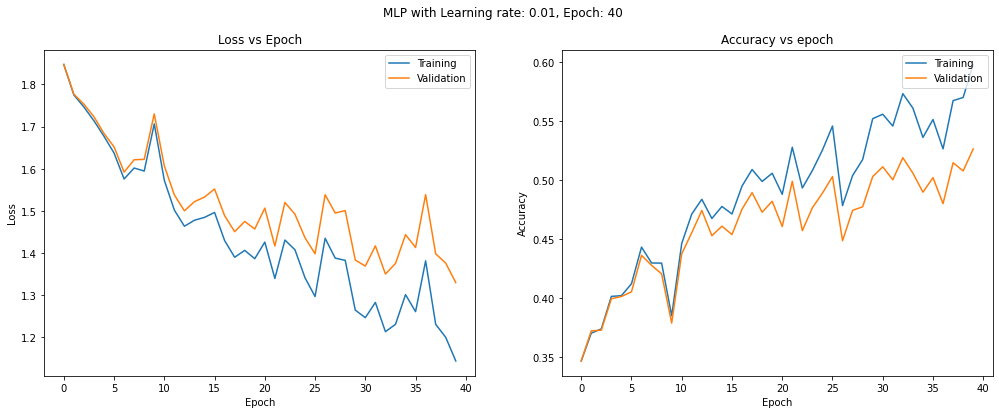

In [212]:
v_s, net = values
loss_train, accuracy_train, loss_validation, accuracy_validation, time_taken_mlp = v_s
graph_data = [loss_train ,loss_validation , accuracy_train, accuracy_validation, "MLP with Learning rate: 0.01, Epoch: 40"]
plot_graphs(graph_data)


In [203]:
print(f"Neural network with lr = 0.01, epochs=40")
print(f"The final training accuracy is {round(accuracy_train[- 1] * 100, 1)}%")
print(f"The final validation accuracy is {round(accuracy_validation[- 1] * 100, 1)} %")
print(f"The final training loss is {round(loss_validation[- 1], 1)}")
print(f"The final validation loss is {round(loss_train[- 1], 1)}")

Neural network with lr = 0.01, epochs=40
The final training accuracy is 59.8%
The final validation accuracy is 52.6 %
The final training loss is 1.3
The final validation loss is 1.1


#### Task 1.1.1 Discuss the convergence of the model.
Using gradient descent, we update the parameters in each layer of our model by moving the parameters in the negative direction of the gradient. Through this, we aim to find the optimal parameters that minimises the cross entropy loss, which inversely increases the classification accuracy for our model. Over the epochs, the training loss of the model decreases, and the training accuracy increases showing that our model converges. In addition, we can see that the accuracy on the validation set increases over the epochs, and that the loss on the validation set decreases as well. This indicates that the MLP model is learning to better predict not only data samples from the training set, but also previously unseen data samples from this validation set. This implies that the performance of the model improves over the epochs and is able to better predict unseen data samples fed into the model, indicating convergence of the model.

### 1.1.2

In [29]:
values_low_lr = mlp_model(x_train, y_train, x_test, y_test, learning_rate=0.0001)

Training Loss for Epoch 1 is 2.2809591901606026
Training Accuracy for Epoch 1 is 0.12178
Validation Loss for Epoch 1 is 2.285236387676526
Validation Accuracy for Epoch 1 is 0.1177
Training Loss for Epoch 2 is 2.2525830820857986
Training Accuracy for Epoch 2 is 0.14538
Validation Loss for Epoch 2 is 2.2571476006399105
Validation Accuracy for Epoch 2 is 0.1409
Training Loss for Epoch 3 is 2.2278133885615947
Training Accuracy for Epoch 3 is 0.1667
Validation Loss for Epoch 3 is 2.232615517414967
Validation Accuracy for Epoch 3 is 0.1618
Training Loss for Epoch 4 is 2.2048748706967367
Training Accuracy for Epoch 4 is 0.1873
Validation Loss for Epoch 4 is 2.2098468885743108
Validation Accuracy for Epoch 4 is 0.1806
Training Loss for Epoch 5 is 2.1835654212872955
Training Accuracy for Epoch 5 is 0.2051
Validation Loss for Epoch 5 is 2.188672673948116
Validation Accuracy for Epoch 5 is 0.1974
Training Loss for Epoch 6 is 2.163655292905375
Training Accuracy for Epoch 6 is 0.22126
Validation Lo

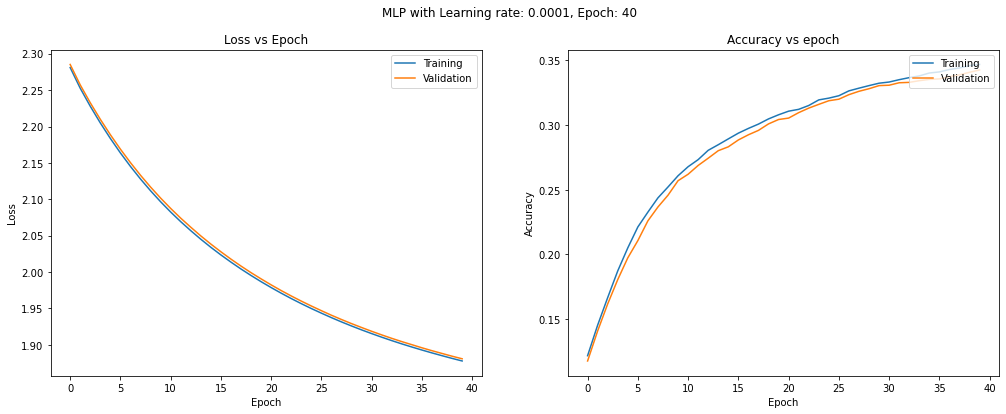

In [213]:
vs_lr, net = values_low_lr
loss_train_low_lr, accuracy_train_low_lr, loss_validation_low_lr, accuracy_validation_low_lr = vs_lr
graph_data = [loss_train_low_lr, loss_validation_low_lr, accuracy_train_low_lr, accuracy_validation_low_lr, "MLP with Learning rate: 0.0001, Epoch: 40"]
plot_graphs(graph_data)

In [141]:
print("Neural network with lr = 0.0001, epochs=40")
print(f"The final training accuracy is {round(accuracy_train_low_lr[- 1] * 100, 1)} %")
print(f"The final validation accuracy is {round(accuracy_validation_low_lr[- 1] * 100, 1)} %")
print(f"The final training loss is {round(loss_train_low_lr[- 1], 1)}")
print(f"The final validation loss is {round(loss_validation_low_lr[- 1], 1)}")

Neural network with lr = 0.0001, epochs=40
The final training accuracy is 34.7 %
The final validation accuracy is 34.3 %
The final training loss is 1.9
The final validation loss is 1.9


In [32]:
values_high_lr = mlp_model(x_train, y_train, x_test, y_test, learning_rate=0.1)

Training Loss for Epoch 1 is 1.8769481908710506
Training Accuracy for Epoch 1 is 0.33238
Validation Loss for Epoch 1 is 1.8777008347720117
Validation Accuracy for Epoch 1 is 0.332
Training Loss for Epoch 2 is 1.8387318347591155
Training Accuracy for Epoch 2 is 0.34796
Validation Loss for Epoch 2 is 1.839293720519345
Validation Accuracy for Epoch 2 is 0.3477
Training Loss for Epoch 3 is 1.7089347667149435
Training Accuracy for Epoch 3 is 0.3838
Validation Loss for Epoch 3 is 1.7195750731905093
Validation Accuracy for Epoch 3 is 0.3786
Training Loss for Epoch 4 is 1.6554478218171644
Training Accuracy for Epoch 4 is 0.41664
Validation Loss for Epoch 4 is 1.67306382426457
Validation Accuracy for Epoch 4 is 0.4063
Training Loss for Epoch 5 is 1.5337094805094447
Training Accuracy for Epoch 5 is 0.45202
Validation Loss for Epoch 5 is 1.561839751013503
Validation Accuracy for Epoch 5 is 0.4479
Training Loss for Epoch 6 is 1.6404101846321708
Training Accuracy for Epoch 6 is 0.41108
Validation L

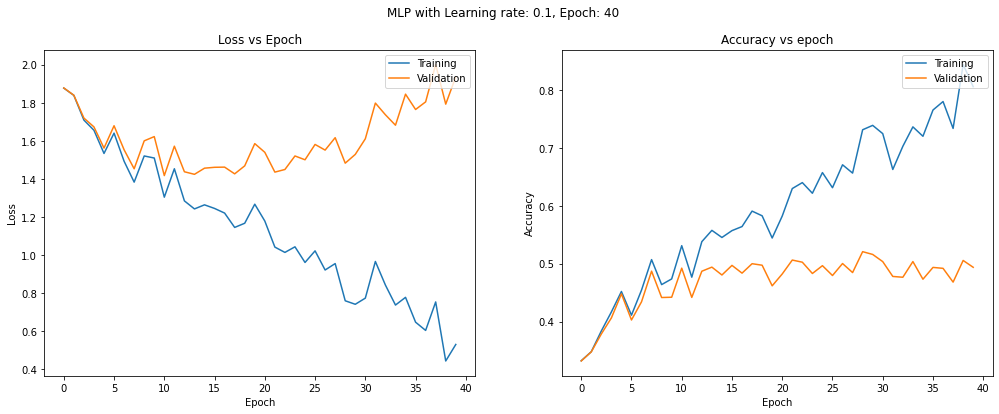

In [214]:
vs_lr_high, net = values_high_lr
loss_train_high_lr, accuracy_train_high_lr, loss_validation_high_lr, accuracy_validation_high_lr  = vs_lr_high
graph_data = [loss_train_high_lr, loss_validation_high_lr, accuracy_train_high_lr, accuracy_validation_high_lr, "MLP with Learning rate: 0.1, Epoch: 40"]
plot_graphs(graph_data)

In [140]:
print("Neural network with accuracy_train_high_lr")
print(f"The final training accuracy is {round(accuracy_train_high_lr[len(accuracy_train_high_lr) - 1] * 100, 1)} %")
print(f"The final validation accuracy is {round(accuracy_validation_high_lr[len(accuracy_validation_high_lr) - 1] * 100, 1)} %")
print(f"The final training loss is {round(loss_train_high_lr[len(loss_train_high_lr) - 1], 1)}")
print(f"The final validation loss is {round(loss_validation_high_lr[len(loss_validation_high_lr) - 1], 1)}")

Neural network with accuracy_train_high_lr
The final training accuracy is 80.6 %
The final validation accuracy is 49.4 %
The final training loss is 0.5
The final validation loss is 1.9


#### Task 1.1.2 Describe and discuss the differences observed in terms of the convergence of the loss and the performance of the models.

Learning Rate| Training Loss | Validation Loss | Training Accuracy | Validation Accuracy
:--- | :---: | :---:| :---: | :---:
**0.01** | 1.1 | 1.3 | 59.8 | 52.6
**0.0001** | 1.9 | 1.9 | 34.7 | 34.3
**0.1** | 0.5 | 1.9 | 80.6 | 49.4


This second neural network uses a smaller learning rate of 0.0001, compared to 0.01 in the first neural network in 1.1.1.

At the end of the 40 epochs, the training loss of this model has a higher value of 1.9 compared to that of 1.3 in 1.1.1. In addition, the training accuracy of the model is at a much lower 34.7% compared to the accuracy rate of 59.8% in 1.1.1. Since the learning rate is small, the parameters are updated much slower in this neural network, causing a slower convergence as compared to the first network. This causes the network to have a poor performance  on unseen data, as seen by the high validation loss values of 1.9 and low validation accuracy values of 34.3% which is similar to the accuracy rate of the model on the training set. Since both accuracy rates and loss values of both training sets and validation sets are similar, this implies that the model has not managed to optimise the parameters in each layer to capture the features that best separates the different classes. This means that the number of epochs of 40 is insufficient to allow this network with a low learning rate to converge.

The third neural network uses a larger learning rate of 0.1, compared to 0.01 in the first neural network.
The convergence of this model is faster than that in the first neural network, as seen from the accuracy rate of close to 80% and the loss value of 0.5 at the end of 40 epochs. Since the learning rate is large, the parameters are updated much faster in this neural network, allowing the model to perform well on the training dataset. However, there are signs of overfitting since the validation loss of the model stops decreasing at around 20 epochs at a low of 1.4, and increases afterwards. In addition, the validation accuracy also displays a slight downward trend after 20 epochs. This implies that the optimal parameters have been overshot due to the large learning rate and we should either use a smaller learning rate or decrease the epochs used to train the model. We could also have an adaptive learning rate which decreases when the parameters are close to optimal.

### 1.1.3

In [43]:
values_80_epochs = mlp_model(x_train, y_train, x_test, y_test, no_epochs=80)

Training Loss for Epoch 1 is 1.883842204911622
Training Accuracy for Epoch 1 is 0.31756
Validation Loss for Epoch 1 is 1.88871064042372
Validation Accuracy for Epoch 1 is 0.3135
Training Loss for Epoch 2 is 1.7714269160623026
Training Accuracy for Epoch 2 is 0.36462
Validation Loss for Epoch 2 is 1.7741575546567885
Validation Accuracy for Epoch 2 is 0.364
Training Loss for Epoch 3 is 1.6965979800862285
Training Accuracy for Epoch 3 is 0.40848
Validation Loss for Epoch 3 is 1.7035293766425177
Validation Accuracy for Epoch 3 is 0.4002
Training Loss for Epoch 4 is 1.678258367224822
Training Accuracy for Epoch 4 is 0.40648
Validation Loss for Epoch 4 is 1.6858398869383922
Validation Accuracy for Epoch 4 is 0.4044
Training Loss for Epoch 5 is 1.6328991059651823
Training Accuracy for Epoch 5 is 0.41708
Validation Loss for Epoch 5 is 1.6465151379781529
Validation Accuracy for Epoch 5 is 0.4111
Training Loss for Epoch 6 is 1.6369884830175192
Training Accuracy for Epoch 6 is 0.42176
Validation 

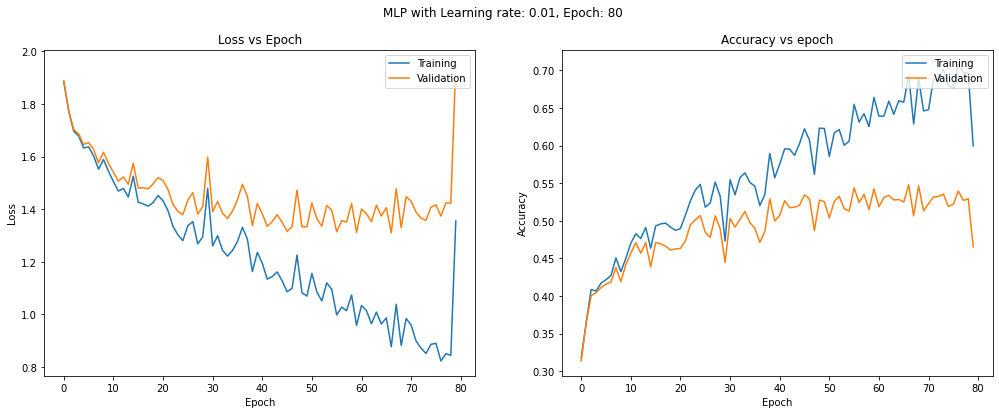

In [215]:
vs, net = values_80_epochs
loss_train, accuracy_train, loss_validation, accuracy_validation = vs
graph_data = [loss_train, loss_validation, accuracy_train, accuracy_validation, "MLP with Learning rate: 0.01, Epoch: 80"]
plot_graphs(graph_data)

In [62]:
print("Neural network with lr = 0.01, epochs=80")
print(f"The final training accuracy is {round(accuracy_train[len(accuracy_train) - 2] * 100, 1)} %")
print(f"The final validation accuracy is {round(accuracy_validation[len(accuracy_validation) - 2] * 100, 1)} %")
print(f"The final training loss is {round(loss_train[len(accuracy_train) - 2 ], 1)}")
print(f"The final validation loss is {round(loss_validation[len(accuracy_train) - 2], 1)}")

Neural network with lr = 0.01, epochs=80
The final training accuracy is 69.7 %
The final validation accuracy is 52.9 %
The final training loss is 0.8
The final validation loss is 1.4


#### Task 1.1.3
In this neural network, the learning rate used is 0.01, and the number of epochs used to train this network is 80.

Learning Rate| Epochs | Training Loss | Validation Loss | Training Accuracy | Validation Accuracy
:--- | :--- | :---:| :---: | :---: | :--:
**0.01** | **40** | 1.1 | 1.3 | 59.8 | 52.6
**0.01** | **80** | 0.8 | 1.4 | 69.7 | 52.9
**0.1** | **40** | 0.5 | 1.9 | 80.6 | 49.4

As compared to the first neural network in 1.1.1 with the same learning rate but a smaller number of epochs of 40, the training loss of the model is a lower value of around 0.8 compared to 1.1 for the first model, and we can see the training accuracy is a higher value of around 70% as compared to 59% for the first model. This is because since we are training the model for a larger number of epochs, we allow the model to continue updating its parameters to more optimal values, enabling the model to converge for a longer time. Hence longer training epochs indicate that our learning rate do not need to be so high. The final dip in training accuracy at epoch 80 corresponding to the final rise in training loss might be due to random noise in the data, but if we continue to run the training for epochs, the final training accuracy and final training loss are expected to continue to increase and decrease respectively. 

The number of epochs required for this model to converge to optimal values is around 66, which is much higher than that required for the third model in 1.1.2 with learning rate of 0.1 of around 20. This is to be expected due to the smaller learning rate of this network, hence the network requires a higher number of epochs to find the optimal parameters of the model.

Similar to the third network, this network also display small signs of overfitting, as shown by the increase in validation loss after epoch 66. The validation accuracy also displays a slightly downward trend after this number of epochs, despite the continual decrease in training loss and increase in training accuracy. The model has overfitted to features found in the training dataset and does not generalise as well to unseen datasets after said number of epochs.


### 1.2 Convolutional Neural network

Using tensorflow, we can implement a convolutional neural network with the following architecture to perform the classification task on the CIFAR-10 dataset of images.

The network should have four hidden layers in total, of which the first three are convolutional layers and the last is a fully-connected layer. All convolutional layers apply a 3 ✕ 3 feature maps, but the first uses 32 and the last two use 64 feature maps. Between the convolutional  there are 2 ✕ 2 maximum pooling layers. The fully-connected layer has 64 neurons and is followed by an output layer with 10 neurons. We should use ReLU as your activation function between all layers, and the softmax function as the activation function on the output layer.

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3,)), #(32, 32, 3) -> (30, 30, 3)
    MaxPool2D((2, 2)), #(30, 30, 3) -> (15, 15, 3)
    Conv2D(64, 3, activation='relu'), # (15, 15, 3) -> (13, 13, 3)
    MaxPool2D((2, 2)),  # (13, 13, 3) -> (6, 6, 3)
    Conv2D(64, 3, activation='relu'), # (6, 6, 3) -> (4, 4, 3)
    Flatten(), 
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
], name="cnn_model")

model.summary()


Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65

In [56]:
# converting dataset into tf.Data objects

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# print the shape of the training tf.Data objects
train_dataset.element_spec

(TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(10,), dtype=tf.float32, name=None))

In [57]:
# shuffle and batch datasets
train_dataset = train_dataset.shuffle(buffer_size=1024)
batch_size = 128

train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [58]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# fix optimisation method to sgd and loss function to be cross entropy
model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])

In [59]:
history = model.fit(train_dataset, epochs=40, validation_data=test_dataset, verbose=False)

In [105]:
def plot_history_graphs(history, title):
    fig = plt.figure(figsize=(17, 6))
    fig.suptitle(title)

    fig.add_subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.legend(['Training', 'Validation'], loc='upper right')

    fig.add_subplot(122)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs epoch")
    plt.show()

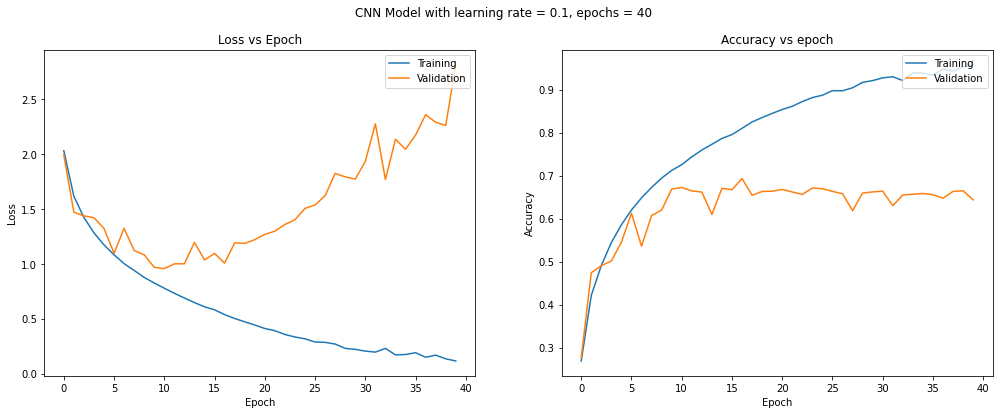

In [106]:
plot_history_graphs(history, "CNN Model with learning rate = 0.1, epochs = 40")

In [65]:
print("CNN with lr = 0.1, epochs=40")
print(f"The final training accuracy is {round(history.history['accuracy'][-1] * 100, 1)} %")
print(f"The final validation accuracy is {round(history.history['val_accuracy'][-1] * 100, 1)} %")
print(f"The final training loss is {round(history.history['loss'][-1], 1)}")
print(f"The final validation loss is {round(history.history['val_loss'][-1], 1)}")

CNN with lr = 0.1, epochs=40
The final training accuracy is 95.9 %
The final validation accuracy is 64.4 %
The final training loss is 0.1
The final validation loss is 2.8


#### Task 1.2.1 Discuss the convergence of the model and any signatures of underfitting or overfitting

As the training progresses over multiple epochs, the loss function converges since the categorical cross entropy loss of the training set decreases with increasing epochs. In addition, the training accuracy of the model increases over the number of epochs. However, the current CNN overfits to the training data, since the loss of the validiation dataset increases after a certain number of epochs (10), which implies that our network does not generalise well to unseen data. Ideally, for a well trained model, the loss value on validiation datasets should converge to a minimum as well. We should choose to stop training the model when the validation data accuracy reaches a maximum, and decreases instead.

### 1.2.2 Regularise the model

The L2 regularisation can be included using kernel_regularizer in all of the convolutional layers. The L2 regularisation adds a small penalty term, the squared of the weights, to the loss function, and is given by 
$$
J = \text{Cross Entropy Loss} + \lambda\sum_w w^2
$$
where $J$ is the updated loss function, and $\lambda$ is the regularisation coefficient.
We can thus obtain the optimal parameters W by finding:

$$
\mathbf{w}^{*}=\underset{\mathbf{w}}{\arg \min }\ J
$$

Using SGD, we can update W using the formula below:

$$
w \leftarrow w-\alpha\left(\frac{\partial L o s s}{\partial w}+2 \lambda w\right)
$$
where $\alpha$ is the learning rate of the model.

In [66]:
from tensorflow.keras import regularizers

l2_coeff = 5e-3

def get_regularized_model():
    # bias_regularizer keyword also present if we want to reg that!
    model = Sequential([
        Conv2D(32, 3, kernel_regularizer=regularizers.l2(l2_coeff), activation='relu', input_shape=(32, 32, 3,)), #(32, 32, 3) -> (30, 30, 3)
        MaxPool2D((2, 2)), #(30, 30, 3) -> (15, 15, 3)
        Conv2D(64, 3, kernel_regularizer=regularizers.l2(l2_coeff), activation='relu'), # (15, 15, 3) -> (13, 13, 3)
        MaxPool2D((2, 2)),  # (13, 13, 3) -> (6, 6, 3)
        Conv2D(64, 3, kernel_regularizer=regularizers.l2(l2_coeff), activation='relu'), # (6, 6, 3) -> (4, 4, 3)
        Flatten(), 
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ], name="reg_cnn_model")
    return model

reg_model = get_regularized_model()
reg_model.summary()

In [68]:
# compile and train the model
reg_model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])

reg_history = reg_model.fit(train_dataset, epochs=40, validation_data=test_dataset, verbose=False)

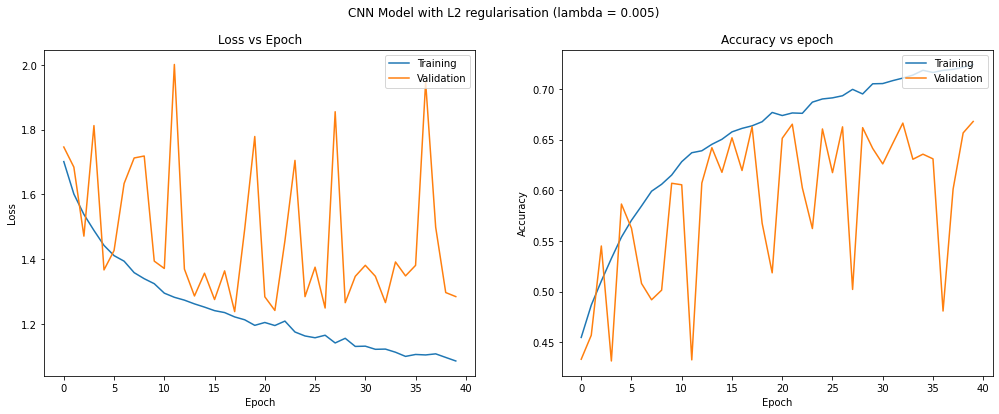

In [107]:
plot_history_graphs(reg_history, "CNN Model with L2 regularisation (lambda = 0.005)")

In [111]:
print("CNN with L2 Regularisation lr = 0.1, epochs=40")
print(f"The final training accuracy is {round(reg_history.history['accuracy'][-1] * 100, 1)} %")
print(f"The final validation accuracy is {round(reg_history.history['val_accuracy'][-1] * 100, 1)} %")
print(f"The final training loss is {round(reg_history.history['loss'][-1], 1)}")
print(f"The final validation loss is {round(reg_history.history['val_loss'][-1], 1)}")

CNN with L2 Regularisation lr = 0.1, epochs=40
The final training accuracy is 72.4 %
The final validation accuracy is 66.8 %
The final training loss is 1.1
The final validation loss is 1.3


#### Task 1.2.2 Compare loss and accuracy of this model to 1.2.1. Explain how the regularisation affects the training procedure.

Model | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss
:-- | :--: |:--: |:--: |:--: |
Without L2 regularisation | 95.9 | 64.4 | 0.1 | 2.8
With L2 regularisation | 72.4 | 66.8 | 1.1 | 1.3

The training accuracy of the model with L2 regularisation has a lower value of 72.4% compared to that of the normal model in 1.2.1 with 95.9%. This shows that the model with the L2 regularisation does not overfit as much to the training dataset and hence can perform better on unseen samples, as seen by the higher validation accuracy of the second CNN model of 66.8% compared to that of the first model of 64.4%. Conversely, the training loss values for the first model is very low at 0.1, while that of the second model is 1.1. Once again, this indicates that the overfitting has been reduced. The second model also generalises better to unseen data samples by having a lower loss value of 1.3 compared to that of model 1 of 2.8.

In L2 regularisation, we modify the loss function by adding the squared weights as a penalty term to the loss function. We want to minimise the loss with respect to this new loss function. This causes large weights to be penalised, pushing the values of weights to zero. This encourages sharing between features, preventing the model from overfitting to the training dataset

### 1.2.3 
We implement both L2 regularisations and dropout in the network below. From research online, the dropout layers for convolutional neural networks are often used after pooling layers as a rough guide. In the neural network below, we only use one dropout layer after the first convolutional layer since this gives us the best results.

In [73]:
from tensorflow.keras.layers import Dropout

dropout_rate = 0.5

def get_reg_dropout_model():
    model = Sequential([
        Conv2D(32, 3, kernel_regularizer=regularizers.l2(l2_coeff), activation='relu', input_shape=(32, 32, 3,)), #(32, 32, 3) -> (30, 30, 3)
        MaxPool2D((2, 2)), #(30, 30, 3) -> (15, 15, 3)
        Dropout(dropout_rate),
        Conv2D(64, 3, kernel_regularizer=regularizers.l2(l2_coeff), activation='relu'), # (15, 15, 3) -> (13, 13, 3)
        MaxPool2D((2, 2)),  # (13, 13, 3) -> (6, 6, 3)
        Conv2D(64, 3, kernel_regularizer=regularizers.l2(l2_coeff), activation='relu'), # (6, 6, 3) -> (4, 4, 3)
        Flatten(), 
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ], name="reg_dropout_cnn_model")
    return model

reg_dropout_model = get_reg_dropout_model()
reg_dropout_model.summary()

Model: "reg_dropout_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)    

Since we want to measure the time taken to train the CNN model, we can implement a timer callback to measure the training time taken for each epoch. We can record these values in a list in the callback object and we take the sum of all these values after the CNN model has been trained.

In [78]:
class Timer(tf.keras.callbacks.Callback):
    def on_train_begin(self, times={}):
        self.times = []
        start = time.time()
    def on_epoch_begin(self, batch, times={}):
        self.start = time.time()
    def on_epoch_end(self, batch, times={}):
        self.times.append(time.time() - self.start)

callback_timer = Timer()
reg_dropout_model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])
reg_dropout_history = reg_dropout_model.fit(train_dataset, epochs=40, validation_data=test_dataset, verbose=False, callbacks=[callback_timer])


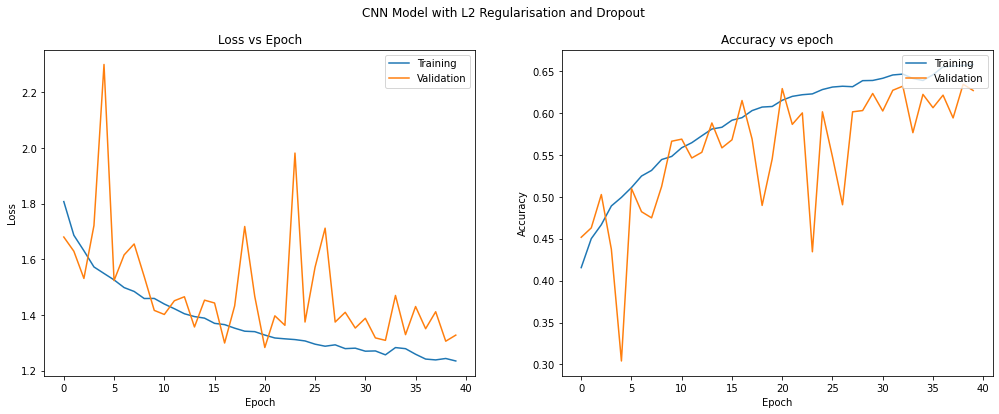

In [109]:
plot_history_graphs(reg_dropout_history, "CNN Model with L2 Regularisation and Dropout")

In [112]:
print("CNN with L2 Regularisation, Dropout, lr = 0.1, epochs=40")
print(f"The final training accuracy is {round(reg_dropout_history.history['accuracy'][-1] * 100, 1)} %")
print(f"The final validation accuracy is {round(reg_dropout_history.history['val_accuracy'][-1] * 100, 1)} %")
print(f"The final training loss is {round(reg_dropout_history.history['loss'][-1], 1)}")
print(f"The final validation loss is {round(reg_dropout_history.history['val_loss'][-1], 1)}")

CNN with L2 Regularisation, Dropout, lr = 0.1, epochs=40
The final training accuracy is 65.8 %
The final validation accuracy is 62.7 %
The final training loss is 1.2
The final validation loss is 1.3


####  Task 1.2.3 Characterize the performance and the effect of the regularisations on the network or the training procedure. Compare the results of the additional regularisations to L2 regularisations above.

Model | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss
:-- | :--: |:--: |:--: |:--: |
With Dropout and L2 regularisation | 65.8 | 62.7 | 1.2 | 1.3
With L2 regularisation | 72.4 | 66.8 | 1.1 | 1.3

We implement both dropout and L2 regularisation in the CNN model above. During training, the dropout layers randomly set some neural activations to zero, and since the dropout rate is 50%, 50% of activations after the first pooling layer is dropped. This prevents the network from relying on any one neuron during training, allowing different neurons to learn different features. During testing, all the neurons are used. Since this model is used together with L2 regularisation, and both regularisation methods reduce overfitting, the training accuracy of our model in 1.2.3 is 65.8% and is slightly lower than that of the model in 1.2.2 which gives a value of 72.4%. The training loss for both models are about the same, 1.2 for the current model and 1.1 for the model in 1.2.2. We can look at the validation accuracy if we want to check if the L2 regularisation is sufficient to reduce the overfitting of our model. Implementing an additional layer of dropout in the current model results in a lower validation accuracy of 62.7%, compared to that of the model in 1.2.2, with value of 66.8%. THis might imply that there is too much regularisation done on the model and the model is unable to learn enough features from the training dataset. We can try to decrease regularisation by only choosing to use either dropout or L2 regularisation. 

In [150]:
# calculate total time taken to train cnn
time_taken_for_cnn = sum(callback_timer.times)
print(f"Time taken to train MLP is {round(time_taken_mlp / 60, 1)} minutes")
print(f"Time taken to train CNN is {round(time_taken_for_cnn / 60, 1)} minutes")


Time taken to train MLP is 12.2 minutes
Time taken to train CNN is 15.9 minutes


#### Task 1.2.4 Compare the results obtained with the MLP in 1.1.1 to the results obtained with the CNN in 1.2.3 with Dropout in terms of accuracy, computational time for training over the same number of epochs, and number of parameters in the models. Explain the observed differences.

We can calculate the number of parameters of the MLP by taking the dimensions of the weight and bias parameters in each layer, giving:
$$
(3072 * 400) + 400 + 4 * (400 + 400 * 400) + 400 * 10 + 10 = 1874810
$$
parameters.

Model | Training Accuracy | Validation Accuracy | Computation time (minutes) | Number of Parameters
:-- | :--: |:--: |:--: |:--: |
CNN with Dropout and L2 regularisation with lr = 0.1 | 65.8 | 62.7 | 15.9 | 122,570
MLP with lr = 0.01 | 59.8 | 52.6 | 12.2 | 1,874,810

The CNN has a better performance as compared to the MLP as seen from the higher training and validation accuracies of 65.8% and 62.7%. There might be two reasons for this. Firstly, the difference might stem from the fact that the learning rate used for CNN is 0.1 while that of MLP is 0.01. The CNN model is thus able to converge faster, and hence able to reach better optimal values in the span of 40 epochs, as compared to the MLP. The second reason is that MLP disregards spatial information while CNN takes into consideration local connectivity and is better able to recognise features that differentiates one class from another. 

The number of parameters for CNN is significantly lower (about 10 times) than that of MLP. This is because the CNN assumes that the inputs are two dimensional and encode certain properties such as local connectivity, since each neuron only sees a small local region in the layer before it, and weight sharing amongst kernels in each layer into the architecture. CNN is thus partially connected while MLP is fully connected, which results in a substantial reduction in the number of parameters, making the computation more efficient.

The computation time for CNN is slightly longer than that of MLP. This is unexpected due to the higher number of parameters of MLP which should take a longer time to optimise. The slightly longer time taken might be due to how keras implements CNN under the hood, which is different from how the MLP is implemented through different classes of layers.

## Task 2: Unsupervised learning



### 2.1 Clustering of the feature matrix

In [217]:
F = np.genfromtxt("./feature_matrix_karate_club.csv", delimiter=',')[1:, 1:]
print(F.shape)

(34, 100)


In [218]:
def normalize(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

F_norm = normalize(F)

### 2.1.1
We implement the k means algorithm as below. 

Step 1. Given number of clusters, k, assign every sample to one of the k clusters at random.

Step 2. Compute the centroid of each of the k clusters:
$$
    \boldsymbol{m_l} = \frac{1}{|c_l|}\sum_{i\in c_l} x^(i), l=1,...,k
$$
Step 3. Reasssign each $\boldsymbol{x^{i}}$ to the closest centroid.

We iterate steps 2 and 3 continuously until the stopping criteria is met.

There are 3 stopping criteria for the k means algorithm: 

1. Positions of centroids of clusters do not change
2. Centroid assignment for each data point remains the same
3. Maximum number of iterations reached.


1 is implemented by calculating the difference in within distance between the previous iteration and the current iteration. If this value is smaller than a small value epsilon, then the algorithm can be halted. 2. is implemented by comparing the centroid assignments between the previous iteration and the current iteration. 

The objective of K means is to minimse the within cluster distance, which is the distance ot the centroids. This can be calculated using the formula below:
$$
\mathcal{W(C)} = \sum_{l=1}\sum_{i\in c_l}||\mathbb{x^{(i)}} - \mathbb{m_l}||^2
$$

given a clustering $\mathcal{C} = \{c_l\}_{l=1}^{k}$, with $\mathbb{m_l}$ being the centroids assigned in the k means algorithm.

In [154]:
# generate random coordinates for centroid from a uniform distribution
def generate_random_centroid():
    _, n_features = F.shape
    max_val = np.max(F, axis=0)
    min_val = np.min(F, axis=0)
    c = np.zeros((n_features))
    for i in range(n_features):
        c[i] = np.random.uniform(min_val[i], max_val[i])
    return c
        

In [155]:
np.random.seed(3632)

def init_centroids(X, k):

    N, n_features =  X.shape
    
    # assign every sample to a cluster at random
    labels = np.random.randint(low=0, high=k, size=N)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)
    # initialise centroids
    centroids = np.zeros((k, n_features))

    for i in range(k):
        n_samples = X_labels[X_labels[:, -1] == i]

        # generate random centroid as the ith centroid if no data points are assigned to ith cluster
        if len(n_samples) == 0:
            centroids[i] = generate_random_centroid()
        else:
            # get mean distances betweeen data points to calculate centroid position
            res = np.mean([x for x in X_labels if x[-1] == i], axis=0)[:-1]
            centroids[i] = res
            
    return labels, centroids

# calculate within distance of centroids
def calc_within_distance(distances, labels, centroids):
    sum = 0
    for i in range(len(centroids)):
        idx = np.argwhere(labels == i)
        sum += np.square(distances[idx]).sum()
    return sum
    
def k_means(X, k, epsilon):
    max_iter = 25

    assigned_labels, centroids = init_centroids(X, k)
    global_c_d = math.inf
    distance_to_centroids = np.zeros(len(X))

    # k-means algorithm
    for i in range(max_iter):
        # print('Iteration:', i)
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)
        distance_to_centroids = np.min(distances, axis=0)

        # calculate within distance of current centroid assignments
        c_d = calc_within_distance(distance_to_centroids, new_labels, centroids)

        if abs(global_c_d - c_d) <= epsilon:
            # within distance has converged
            break
        else:
            global_c_d = c_d

        if (assigned_labels==new_labels).all():
            # labels unchanged, Centroid assignments unchanged!
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(assigned_labels!=new_labels)    
            # print('%4f%% labels changed' % (difference * 100))
            assigned_labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (assigned_labels == c).any():
                    centroids[c] = np.mean(X[assigned_labels==c], axis=0)
    
    w_d = calc_within_distance(distance_to_centroids, assigned_labels, centroids)
    
    return centroids, assigned_labels, w_d

The outcome of k means clustering depends on the initialisation of the chosen centroids. In addition, since the algorithm is a heuristic to help us find the best way to cluster our data points to minimise the within distancee of our centroids, there is a lack of guarantee for global optimality in a single k means algorithm. To tackle this problem, for a certain k value, we can run k-means many times with different random initialisations to obtain an ensemble of optimised clusters. This can be repeated over various k values. We can then choose the optimal k that gives the lowest within distance. 

In [156]:
# run N times of k means with different initialisations
def k_means_ensemble(X, k, epsilon, N):
    sum_w_d = 0
    combined_centroids = []
    combined_labels = []

    for i in range(N):
        centroids, assigned_labels, global_w_d = k_means(X, k, epsilon)
        sum_w_d += global_w_d
        combined_centroids.append(np.array(centroids))
        combined_labels.append(np.array(assigned_labels))

    return sum_w_d / N, np.array(combined_centroids), np.array(combined_labels)

# perform k means ensemble for k values between 2 and 10 inclusive
def perform_clustering(X, epsilon, N):
    w_ds = []
    all_centroids = []
    all_labels = []
    for i in range(2, 11):
        average_wd, centroids, labels = k_means_ensemble(X, i, epsilon, N)
        w_ds.append(average_wd)
        all_centroids.append(centroids)
        all_labels.append(labels)
    return w_ds, all_centroids, all_labels


In [639]:
k_means_w_ds, k_means_centroids, k_means_labels = perform_clustering(F, epsilon=1e-10, N=100)

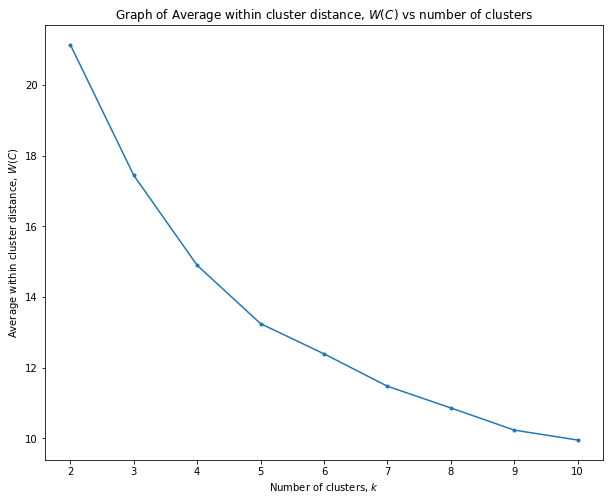

In [640]:
import matplotlib.pyplot as plt

def plot_k_means_graph(y_label, y):

    plt.figure(figsize=(10, 8))
    plt.plot(list(range(2, 11)), y, marker='.')
    plt.xlabel(f"Number of clusters, $k$")
    plt.ylabel(f"{y_label}")
    plt.title(f"Graph of {y_label} vs number of clusters")

plot_k_means_graph("Average within cluster distance, $W(C)$", k_means_w_ds)

####  Task 2.1.1
The average within cluster distance decreases as k increases. However, the rate of decrease decreases sharply from k = 2 to k = 4, and there is a sharp decrease in the gradient of the graph at k = 4. The rate of decrease gradually decreases from k = 4 onwards.
From the graph above, we can use the 'elbow' method to choose the optimal number of clusters, k for our data set. We have run k means multiple times on a range of k from 2 to 10, and we want to choose the smallest k that gives us a small $\mathcal{W(C)}$. We can choose the optimal k to be the k where the rate of decrease sharply shifts, which is k = 4.

### 2.1.2
Alternatively, we can use the Calinski-Harabasz Score to find the optimal number of clusters for our data set. The CH score is a measure of how similar a data point is to the cluster it is assigned to (within cluster variation), compared to the other clusters (between cluster variation). Within cluster variation is estimated based on the distance from the data points in a cluster to the centroid of that cluster, while between cluster variation is calculated based on the distance of the centroids to the global centroid, which is taken by the mean of all centroids.

The Calinski-Harabasz Score can be calculated by the formula:

$$
    \mathcal{CH(k)} = \frac{\mathcal{B(k)}}{\mathcal{W(k)}} * \frac{n - k}{k - 1}
$$

where n is the number of data points in the dataset, k is the number of clusters, $\mathcal{B(k)}$ is the between cluster variation and $\mathcal{W(k)}$ is the within cluster variation. Again, $\mathcal{W(k)}$ can be calculated using the formula from above, and $\mathcal{B(k)}$ is the distance between clusters and can be calculated using the formula below:

$$
 \mathcal{B(k)} = \sum_{k = 1}^{K} \mathcal{n_k} || \mathcal{c_k} - \mathcal{c}||^2
$$

where $\mathcal{n_k}$ and $\mathcal{c_k}$ is the number of points assigned to the kth cluster and the centroid of the kth cluster respectively, c is the global centroid, which is the mean of all centroids.




In [370]:
# calculate between cluster distance of clustering
def calc_b_k(centroids, labels, X):
    b_k = 0
    # take mean of all centroids
    global_centroid = np.mean(centroids, axis=0)
    for i in range(len(centroids)):
        # get index of nodes that are classified to label i
        idx = np.argwhere(labels == i)
        # get points assigned to label i
        cluster_k = X[idx]
        centroid_k = centroids[i]
        b_k += len(cluster_k) * np.sum((centroid_k - global_centroid) ** 2)
    return b_k

# run N times of k means with different initialisations and compute the average ch_score for each k
def k_means_ensemble_with_ch_score(X, k, epsilon, N):
    sum_ch = 0
    n, _ = X.shape
    labels = []
    for i in range(N):
        centroids, assigned_labels, w_d = k_means(X, k, epsilon)
        b_k = calc_b_k(centroids, assigned_labels, X)
        ch = b_k * (n - k) / (w_d * (k - 1))
        sum_ch += ch
        labels = assigned_labels
    return sum_ch / N, labels

# perform k means ensemble for k values between 2 and 10 inclusive
def perform_clustering_chs(X, epsilon, N):
    chs = []
    labels = []
    for i in range(2, 11):
        average_ch, label = k_means_ensemble_with_ch_score(X, i, epsilon, N)
        chs.append(average_ch)
        labels.append(label)
        
    return chs, labels

In [371]:
np.random.seed(3632)
chs, labels = perform_clustering_chs(F, 1e-15, 100)


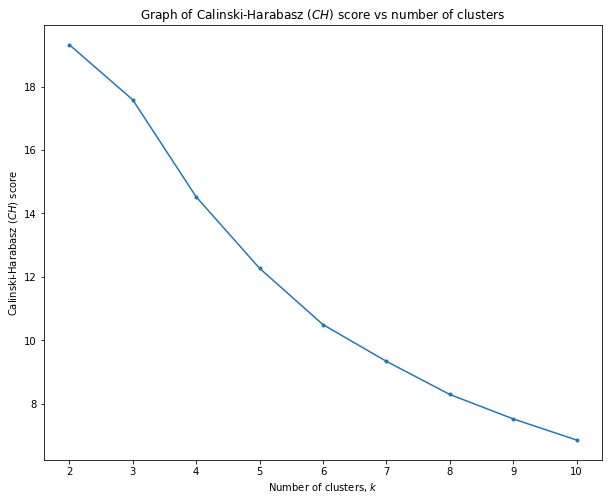

In [372]:
plot_k_means_graph("Calinski-Harabasz $(CH)$ score", chs)

In [374]:
labels_for_optimal_ch_clustering = labels[0]

#### Task 2.1.2
Similar to the within cluster distance, the CH score can also be used to choose the optimal number of clusters for our data set. A higher CH score indicates dense, well separated clusters, since this implies that B(k) is high while W(k) is low. We want to choose a k that gives a peak on the graph above. Since k = 2 gives us the highest CH score, the optimal number of clusters based on the CH score is 2.

### 2.1.3
Since we perform k-means many times with different random initialisations to tackle the problem of k means converging to a local optimum, we get an ensemble of 100 solutions for each k. An alternative way of choosing the optimal k is to evaluate the robustness of the obtained clusterings for each k. A clustering is robust if the clusterings across the ensemble is similar. An optimal k will have similar clusters, and hence give a robust solution.

For the ensembles of each k, we can compare all the clusters pairwise and compute the average ARI score. The formula for ARI is given below:

$$
A R I=\frac{\sum_{i j}\left(\begin{array}{c}
n_{i j} \\
2
\end{array}\right)-\left[\sum_{i}\left(\begin{array}{c}
a_{i} \\
2
\end{array}\right) \sum_{j}\left(\begin{array}{c}
b_{j} \\
2
\end{array}\right)\right] /\left(\begin{array}{c}
n \\
2
\end{array}\right)}{\frac{1}{2}\left[\sum_{i}\left(\begin{array}{c}
a_{i} \\
2
\end{array}\right)+\sum_{j}\left(\begin{array}{c}
b_{j} \\
2
\end{array}\right)\right]-\left[\sum_{i}\left(\begin{array}{c}
a_{i} \\
2
\end{array}\right) \sum_{j}\left(\begin{array}{c}
b_{j} \\
2
\end{array}\right)\right] /\left(\begin{array}{c}
n \\
2
\end{array}\right)}
$$

where i is the row number, j is the column number, a is the row sum, b is the column sum and $n_{ij}$ is the number of data points in common between $X_i$ and $Y_j$, and n is the number of data points

Further explanation of ARI is given below in Section 2.3.3





In [216]:
import math

In [753]:
ROW_SUM = -1
COL_SUM = -1

# form the contigency table for the two clusterings
def gen_count_mat(labels_1, labels_2):
    data = {'cluster 1': labels_1, 'cluster 2': labels_2} 
    # create dataframe of the labels into two clusters
    df = pd.DataFrame(data, columns=['cluster 1', 'cluster 2'])
    #calculate frequencies of objects in common betwen the clusters
    count_mat = pd.crosstab(df['cluster 1'], df['cluster 2']) 
    
    # add Row sum and column sum to the dataframe
    count_mat["ROW_SUM"] = count_mat.sum(axis=1)
    count_mat = count_mat.append(count_mat.sum(axis=0), ignore_index=True)

    return np.array(count_mat)

# compute the ari score given labels of two clusterings
def compute_ari(labels_1, labels_2):
    count_matrix = gen_count_mat(labels_1, labels_2)
    rows = len(np.unique(labels_1))
    cols = len(np.unique(labels_2))

    # compute combinatorial sum for (ai, 2) and (bi, 2) respectively
    a_comb_sum = sum([math.comb(a_i, 2) for a_i in count_matrix[:rows, -1]])
    b_comb_sum = sum([math.comb(b_j, 2) for b_j in count_matrix[COL_SUM, :cols]])
    n = A.shape[0]

    # calculate sum of math.comb(nij, 2)
    t1 = 0
    for i in range(rows):
        for j in range(cols):
            nij_comb = math.comb(count_matrix[i, j], 2)
            t1 += nij_comb
    
    # calculate the second term in numerator
    t2 = a_comb_sum * b_comb_sum / math.comb(n, 2)

    numer = t1 - t2
    denom = (a_comb_sum + b_comb_sum) / 2 - t2
    return numer / denom
    

In [758]:
# since we have N = 100 clusterings for each k, we compute the average ari score for each of these pairwise clusterings
def compute_average_ari_score(labels):
    N = len(labels)
    sum_ari = 0
    comparisons = 0
    for i in range(N):
        for j in range(i + 1, N):
           ari = compute_ari(labels[i], labels[j])
           sum_ari += ari
           comparisons += 1

    return sum_ari / comparisons

# compute average ari for a range of k
def compute_ari_for_all_k(labels):
    avg_aris = []
    for label in labels:
        avg_ari = compute_average_ari_score(label)
        avg_aris.append(avg_ari)
    return avg_aris

ari_scores = compute_ari_for_all_k(k_means_labels)

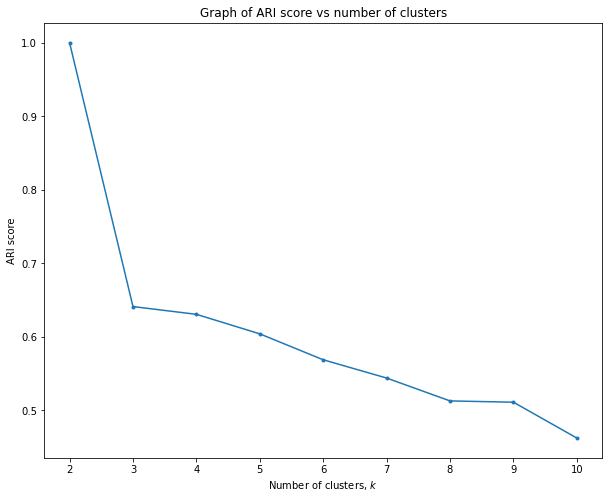

In [763]:
plot_k_means_graph("ARI score", ari_scores)

#### Task 2.1.3
We want to find the optimal number of clusters, k, such that the data points are consistently grouped into the same k clusters. This would then indicate that a partition into k groups does accurately capture the intrinsic properties of the dataset. 

The Adjusted Rand Index gives us a score of the similarity or overlap of the two different clusterings obtained, adjusted for the chance of random overlaps, where data points are randomly assigned to different clusters. A high positive value of ARI indicates that the two clusters are very similar and concurs with each other. An ARI value of 0 indicates that the clusterings are no better than the chances of overlap of a random set. A negative ARI value indicates that the amount of overlap is less than what is expected from a random result, and implies that these clusterings might be complementary to some extent. 

Since a cluster number of 2 gives us the highest ARI score of 1, this indicates that the samples in the dataset are always grouped into the same clusters and the optimal number of clusters, k is 2.



### 2.2 Dimensionality reduction

Since the dimensions for the samples in the karate club dataset is 100, and is very largewee want to find a description of the data set that captures as much information as possible from the original data in reduced dimensions, m. We can approximate $x^i$ in m dimensions using:

$$
\mathbf{x}^{(i)}=\sum_{j=1}^{m} a_{j}^{(i)} \phi_{j} + \sum_{j=m + 1}^p b_{j}\phi_j
$$

where $b_j$ is not dependent on i, and $a_{j}^{(i)}$ is the coefficeients obtained as dot products on the basis, $\phi_j \in \mathbf R^p$ is a basis function. 

We can write down the error made from this assumption:
$$
\Delta \mathbf{x}^{(i)}=\mathbf{x}^{(i)}-\mathbf{x}_{m}^{(i)}=\sum_{j=m+1}^{p}\left[a_{j}^{(i)}-b_{j}\right] \phi_{j}
$$

and we want to minimse the mean square error to find the best description for the data, given as below:

$$
\text{MSE} = \frac{1}{N}\sum_{i=1}^N\sum_{j=m + 1}^p (a_j^{(i)} - b_j)^2
$$


To compute the optimum $\phi_j$, we can rewrite the MSE in terms of the covariance matrix $\mathbf C_x$:

$$
\text{MSE} = \sum_{j=m + 1}^p \phi_j^TC_x\phi_j
$$

We can then find the orthonormal $\phi_j$ by using a lagrangian optimistion, which gives us the solution:
$$
    C_x\phi_j^* = \lambda_j\phi_j^*
$$

This shows that the Lagrange multiplies $\lambda_j$ are eigenvalues of $C_x$ with corresponding eigenvectors $\phi_j$.

Now, we can once again rewrite the MSE using the results from above, obtaining:
$$
MSE = \sum_{j=m + 1}^{p} \phi_j^T\lambda_j\phi_j = \sum_{j=m+1}^{p} \lambda_j
$$

where $\lambda_j$ is the eigenvalues of eigenvector $\phi_j$. This implies that the error is the sum of eigenvalues discarded when reducing dimensions from p to m.


We will implement PCA for this task to plot the data points in F as points in the d-dimensional PCA space for dimensions d = 1, d = 2, d = 3. To perform PCA, we follow the steps below:

1. Compute the covariance matrix  $\mathbf C = \mathbf F^\top \mathbf F/(n-1)$
2. Find eigenvalues and corresponding eigenvectors for the covariance matrix, $\mathbf C = \mathbf V \mathbf L \mathbf V^\top,$
3.  Sort by the largest eigenvalues and the corresponding eigenvectors.
4.  Compute the projection onto the spaced spanned by the top $n$ eigenvectors.

In addition, we perform standardisation on F to ensure that the data have similar scales since PCA is sensitive to the variances of the initial variables. 


In [234]:
from scipy.sparse import linalg

def pca(X, k):
    n, _ = X.shape
    # create covariance matrix S
    C = (X.T @ X) / (n - 1)

    # compute largest eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True)

    # sort the eigenvectors and eignevalues in decreasing order
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:, sorted_index]

    # compute projection
    X_pca = X @ eigenvectors

    return X_pca, eigenvectors, eigenvalues

In [641]:
# Get values of samples of dataset in 1-D PCA space
x_pca_d1, e_vec_d1, e_val_d1 = pca(F_norm, 1)


In [236]:
# Get values of samples of dataset in 2-D PCA space
x_pca_d2, e_vec_d2, e_val_d2 = pca(F_norm, 2)

In [222]:
# Get values of samples of dataset in 3-D PCA space
x_pca_d3, e_vec_d3, e_val_d3 = pca(F_norm, 3)

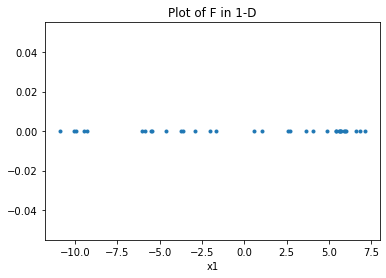

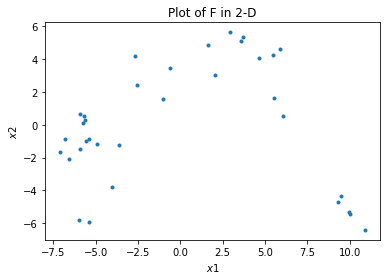

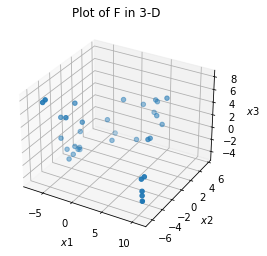

In [644]:
plt.figure()
plt.scatter(x_pca_d1, [0 for x in range(len(F))], marker=".")
plt.title("Plot of F in 1-D")
plt.xlabel("x1")
plt.show()

plt.figure()
plt.scatter(x_pca_d2[:, 0], x_pca_d2[:, 1], marker=".")
plt.title("Plot of F in 2-D")
plt.xlabel(f"$x1$")
plt.ylabel(f"$x2$")
plt.show()

ax = plt.axes(projection='3d')

ax.scatter3D(x_pca_d3[:, 0], x_pca_d3[:, 1], x_pca_d3[:, 2])
ax.set_title("Plot of F in 3-D")
ax.set_xlabel(f"$x1$")
ax.set_ylabel(f"$x2$")
ax.set_zlabel(f"$x3$")
plt.show()




#### Task 2.2.1 Do you find any relation of these projections with the clustering results obtained in 2.1?

From the scatter plots above, we can observe the different clusters the data points are divided into, and approximate the number of clusters in the data set. The 1-D plot shows the data points being divided into 3 separate clusters, namely x < -10, -6 < x < -1 and x > 0. In the 2-D plot, the separation between the data points become clearer, and we can see that there are now 4 clusters, x2 > 1, x1 > 9,  -2 < x2 < 1 and x2 > -2. In the 3-D plot, we can observe that the data points are separated into 4 separate clusters as well, and the separation between the different clusters become more obvious. 

The optimal number of clusters obtained from different metrics in 2.1 is given in the table below:

Metric|     Optimal number of clusters, k 
:--- | :---: 
**Within-distance** | 4
**CH Score** | 2
** Robustness ** | 2

There is a clearer relation between higher dimension projections, d = 2 and d = 3 and the clustering results obtained for within-distance, since they both have the same number of clusters of 4. At d = 2 and d = 3, the separation between clusters become more obvious. This is to be expected since as d increases, the error from the discarded remaining dimensions decreases and the basis vectors obtained forms a better representation of the original dataset. When d = 1, even though the basis that explains the largest variance in the original dataset is chosen to describe the dataset, we are unable to fully describe all the features and variances in the original dataset in just one single dimension, hence the difference in number of clusters obtained.

Since the number of optimal clusters obtained for CH score is 2, there is not much of a relation between this and the clusters observed from the 3 plots above. The data points do not seem to separate clearly into 2 different clusters from the 3 PCA plots.

The above is the same for the optimal number of clusters obtained by evaluating the robustness of the clusterings for each k.


### 2.2.2
We know that in PCA, the eigenvectors of the covariance matrix, otherwise known as principal components, represents the directions of the axes with the most variance, while the respective eigenvalues gives us the amount of variance carried by each principal component. To calculate the explained variance of the reduced dimensions, we obtain all the eigenvalues of the covariance matrix, and sort them in descending order. Since variance is additive, the total explained variance can be calculated by:

$$
Explained\ Var(k) = \frac{\sum_{i=1}^{k} \sigma_{i}}{Total \ variance}
$$

where total variance is the sum of all eigenvalues, $\sigma_{i}$ is the $ith$ largest eigenvalue, $k$ is the kth reduced dimension.

In [269]:
def find_explained_variances(X):
    cov_matrix = X.T @ X / (len(X) - 1)
    all_eigenvalues, _ = np.linalg.eig(cov_matrix)
    
    # calculate the sum of all variances of X
    total_var = abs(all_eigenvalues.sum())

    # sort all eigenvalues in descending order
    all_eigenvalues = sorted(all_eigenvalues)[::-1]
    explained_vars = []

    for i in range(1, 11):
        e_val = all_eigenvalues[:i]
        var = sum(e_val) / total_var
        explained_vars.append(var)
    
    return explained_vars

In [266]:
vars = find_explained_variances(F_norm)

In [646]:
for i, var in enumerate(vars):
    print(f"Dimension {i + 1} has explained variance of {round(var * 100, 1)}%")

Dimension 1 has explained variance of 35.1%
Dimension 2 has explained variance of 48.4%
Dimension 3 has explained variance of 59.5%
Dimension 4 has explained variance of 65.3%
Dimension 5 has explained variance of 70.2%
Dimension 6 has explained variance of 74.2%
Dimension 7 has explained variance of 77.6%
Dimension 8 has explained variance of 80.7%
Dimension 9 has explained variance of 83.6%
Dimension 10 has explained variance of 86.4%


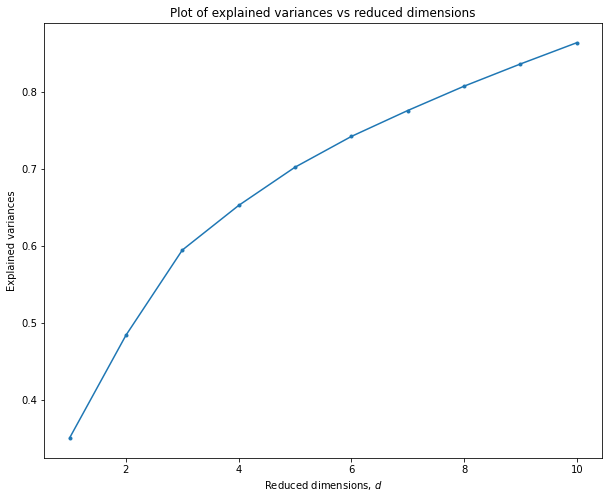

In [268]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), vars, marker=".")
plt.title("Plot of explained variances vs reduced dimensions")
plt.xlabel(f"Reduced dimensions, $d$")
plt.ylabel(f"Explained variances")
plt.show()

#### Task 2.2.2
The covariance matrix is computed using $F^TF$, where $F$ is the normalised feature matrix. We can apply spectral decompostiion to this matrix by calculating the eigenvectors and the corresponding eigenvalues sorted in descending order that expresses the k rank approximation to the covariance matrix, as shown by: 
$$
    F^TF = U_k\Sigma_k V_k^T
$$

where $\Sigma$ is the ordered singular values and $V_k$ are the k singular vectors.

Since the eigenvectors give the directions of axes with the most information, and the corresponding eigenvalues give the total amount of variance carried by each eigenvector, we want to choose the top k eigenvector with the largest eigenvalues, so that the data is best described by the reduced dimeension.  

From the graph, we can see that the data is well described in a reduced dimension of 10 since the proportion of explained variances when k = 10 is 85%, which is a rather accurate explanation of the original dataset. 

The proportion of explained variances increases as k increases. This is to be expected since we use the eigenvectors corresponding to the top k eigenvalues, that represents the directions of the axes explaining the top k variance, since the eigenvalues give us the respective variance carried by each eigenvector. Since variance is additive, as k increases, the variance explained by the increasing number of eigenvectors increases as well. 

### 2.3 Graph based analysis

In [162]:
# importing adjacency matrix A
A = np.genfromtxt("./karate_club_graph.csv", delimiter=',')[1:, 1:]
print(A.shape)

(34, 34)


### 2.3.1 Centralities

We calculate graph centrality as a way to rank samples and find the most important nodes or edges in a graph. There are many ways to compute centrality, and the ones that will be used are degree centrality, eigenvector centrality and PageRank.

To compute degree centrality, the importance of each node is defined to be its degree, which is calculated as follows:
$$
\boldsymbol c_d = \frac{\boldsymbol d}{2 * E}
$$
where d is the degree of each node, which can be calculated as the sum of all the columns in the adjacency matrix for each node, and E is the total number of edges in the graph.


In [163]:
import networkx as nx
import pandas as pd 

In [164]:
# show graph using networkx
def show_graph(A, node_color):
    g = nx.Graph(A)
    #relabels nodes to start from index 1
    g_new_nodes = nx.relabel_nodes(g, lambda x: x + 1)
    pos = nx.spring_layout(g_new_nodes)
    nx.draw(g_new_nodes, node_color=node_color, pos=pos, with_labels=True, font_color='white')


In [165]:
# compute degree of each node
total_edges = A.sum() / 2
degree_centrality = A.sum(axis=1) / (2 * total_edges)

In [166]:
deg_centrality_df = pd.DataFrame({"Nodes": list(range(1, A.shape[0] + 1)), "Degree Centrality" :degree_centrality})
# limit values printed to 4dp
deg_centrality_df = deg_centrality_df.apply(lambda x: round(x, 4))
# sort df by eigenvector centrality in decreasing order
deg_centrality_df.sort_values(by=["Degree Centrality"], inplace=True, ascending=False)
print(deg_centrality_df.to_string(index=False))
# show_graph(A, node_color=degree)

 Nodes  Degree Centrality
    34             0.1090
     1             0.1026
    33             0.0769
     3             0.0641
     2             0.0577
     4             0.0385
    32             0.0385
    24             0.0321
     9             0.0321
    14             0.0321
    28             0.0256
    30             0.0256
    31             0.0256
     8             0.0256
     7             0.0256
     6             0.0256
    11             0.0192
    29             0.0192
     5             0.0192
    20             0.0192
    26             0.0192
    25             0.0192
    27             0.0128
    19             0.0128
    23             0.0128
    22             0.0128
    21             0.0128
    17             0.0128
    16             0.0128
    15             0.0128
    13             0.0128
    10             0.0128
    18             0.0128
    12             0.0064


To find the eigenvector centrality, we want to find the eigenvector corresponding to the largest eigenvalu of A. We can use linalg.eigsh to find the largest eigenvalue and the corresponding eigenvector. Here, we normalize the values of the eigenvector by dividing each element in the eigenvector by the sum of all the elements to allow us to compare the correlation between the centrality values obtained from different measures of centrality.

In [170]:
# compute eigenvector associated with largest eigenvalue
from scipy.sparse import linalg

largest_eval, largest_evec = linalg.eigsh(A, 1, which='LM', return_eigenvectors=True)


In [171]:
# normalise values for comparison
normalize_evec = largest_evec / largest_evec.sum()

ev_centrality_df = pd.DataFrame({"Nodes": list(range(1, A.shape[0] + 1)), "Eigenvector Centrality" :normalize_evec.flatten()})
# limit values printed to 4dp
ev_centrality_df = ev_centrality_df.apply(lambda x: round(x, 4))
# sort df by degree centrality in decreasing order
ev_centrality_df.sort_values(by=["Eigenvector Centrality"], inplace=True, ascending=False)
print(ev_centrality_df.to_string(index=False))
# show_graph(A, node_color=largest_evec)

 Nodes  Eigenvector Centrality
    34                  0.0750
     1                  0.0714
     3                  0.0637
    33                  0.0620
     2                  0.0534
     9                  0.0457
    14                  0.0455
     4                  0.0424
    32                  0.0384
    31                  0.0351
     8                  0.0343
    24                  0.0302
    20                  0.0297
    30                  0.0271
    28                  0.0268
    29                  0.0263
    10                  0.0206
    23                  0.0204
    21                  0.0204
    19                  0.0204
    16                  0.0204
    15                  0.0204
    22                  0.0186
    18                  0.0186
    13                  0.0169
     7                  0.0160
     6                  0.0160
    11                  0.0153
     5                  0.0153
    27                  0.0152
    26                  0.0119
    25  

In [172]:
# The sum of all the elements in the normalised eigenvector is 1
normalize_evec.sum()

1.0000000000000002

The PageRank centrality of each node is given by the elements of the stationary eigenvector, obtained by solving the equation below:
$$
\boldsymbol c_{PR} = \alpha(\boldsymbol A \boldsymbol D^{-1})\boldsymbol c_{PR} + (1 - \alpha) \frac{\boldsymbol 1}{N}
$$
where $\alpha$ is the teleportaion parameter that regulates how much the random walk follows the graph or jumps unrestricted, arbitrarily set at 0.85, N is the total number of nodes in the graph, $A$ is the adjacency matrix, and $D$ = $diag(\boldsymbol d)$ which contains the degree vector $d$ on the diagonal.

Rewriting, we have:

$$
(I - \alpha(\boldsymbol A \boldsymbol D^{-1})) \boldsymbol c_{PR} = (1 - \alpha) \frac{\boldsymbol 1}{N}
$$

where I is the identity matrix, and we can solve for $c_{PR}$.

Normally, the PageRank algorithm is applied to a directed graph to model the flow of information from one webpage to another, hence we cannot assume that the links between both pages are bidirectional. However, since we are given the adjacency matrix of the karate club that models the social network of friendships between the members of the club, we can assume that there are no one-sided friendships and that the graph is undirected. 

In [173]:
# calculate pagerank centrality of nodes by treating the equation above as a linear equation
def calc_pagerank():
    alpha = 0.85

    # calculate degree of adjacency matrix
    degree = A.sum(axis=1)
    # compute D inverse
    diag = np.diag(degree)
    inv_D = np.linalg.inv(diag)

    # compute constants used in formula
    I = np.eye(A.shape[0])
    N = A.shape[0]
    ones = np.ones(A.shape[0])

    return np.linalg.solve(I - alpha * A @ inv_D, (1 - alpha) * ones / N)

pagerank_ev = calc_pagerank()

In [174]:
pagerank_ev_df = pd.DataFrame({"Nodes": list(range(1, A.shape[0] + 1)), "Pagerank Centrality" :pagerank_ev})
# limit values printed to 4dp

pagerank_ev_df = pagerank_ev_df.apply(lambda x: round(x, 4))
# sort df by pagerank centrality in decreasing order
pagerank_ev_df.sort_values(by=["Pagerank Centrality"], inplace=True, ascending=False)
print(pagerank_ev_df.to_string(index=False))

 Nodes  Pagerank Centrality
    34               0.1009
     1               0.0970
    33               0.0717
     3               0.0571
     2               0.0529
    32               0.0372
     4               0.0359
    24               0.0315
     9               0.0298
    14               0.0295
     7               0.0291
     6               0.0291
    30               0.0263
    28               0.0256
    31               0.0246
     8               0.0245
    11               0.0220
     5               0.0220
    25               0.0211
    26               0.0210
    29               0.0196
    20               0.0196
    17               0.0168
    27               0.0150
    18               0.0146
    22               0.0146
    13               0.0146
    23               0.0145
    21               0.0145
    16               0.0145
    15               0.0145
    19               0.0145
    10               0.0143
    12               0.0096


In [175]:
print("The top 10 highly central nodes for Degree centrality are: ")
print(deg_centrality_df[:10].to_string(index=False))
print("\n")
print("The top 10 highly central nodes for Eigenvector centrality are: ")
print(ev_centrality_df[:10].to_string(index=False))
print("\n")
print("The top 10 highly central nodes for PageRank are: ")
print(pagerank_ev_df[:10].to_string(index=False))
print("\n")

The top 10 highly central nodes for Degree centrality are: 
 Nodes  Degree Centrality
    34             0.1090
     1             0.1026
    33             0.0769
     3             0.0641
     2             0.0577
     4             0.0385
    32             0.0385
    24             0.0321
     9             0.0321
    14             0.0321


The top 10 highly central nodes for Eigenvector centrality are: 
 Nodes  Eigenvector Centrality
    34                  0.0750
     1                  0.0714
     3                  0.0637
    33                  0.0620
     2                  0.0534
     9                  0.0457
    14                  0.0455
     4                  0.0424
    32                  0.0384
    31                  0.0351


The top 10 highly central nodes for PageRank are: 
 Nodes  Pagerank Centrality
    34               0.1009
     1               0.0970
    33               0.0717
     3               0.0571
     2               0.0529
    32               0.03

#### Task 2.3.1
(i)

Study which nodes (if any) are highly central according to the three centralities.

We take the id of the nodes as the index of the nodes, with index starting at 1, and we consider the top 10 highly central nodes. 

The top ranking nodes are all quite similar across the different centrality measures, with each node having a different ranking across all 3 measures. The nodes 34 and 1 are the top 2 ranking nodes with the highest centrality across all 3 measures. The nodes 33, 3 and 2 are the 3rd, 4th and 5th most central nodes according to both pagerank and degree centralities. In eigenvector centrality there is a slight difference in the rankings, where node 3 is ranked before 33, followed by node 2. The 6th and 7th rankings differ for both degree and pagerank centralities, having node 4 and node 32, and node 32 and node 4 respectively. The nodes for these rankings for eigenvector centrality is 9 and 14. Lastly, nodes 24, 9, 14 are ranked 8th, 9th and 10th in both pagerank and degree centrality. Nodes 4, 32, 31 takes these places for eigenvector centrality.

Further discussions follow after the graphs are plotted below.




In [360]:
data = {"degree": degree_centrality, "eigenvector": normalize_evec.flatten(), "pagerank": pagerank_ev}
centralities_df = pd.DataFrame(data)

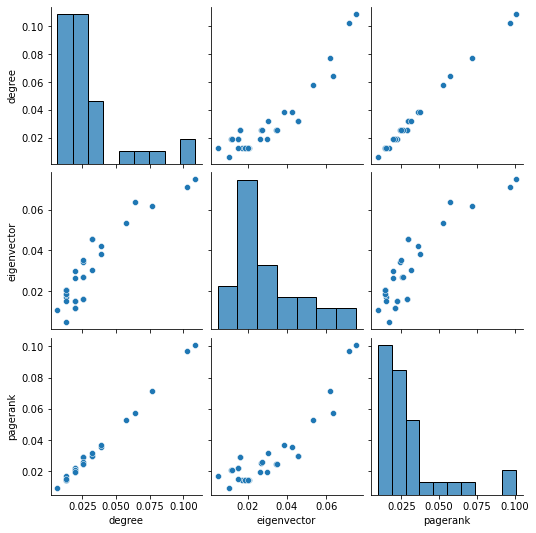

In [363]:
import seaborn as sns

sns.pairplot(data=centralities_df)

<AxesSubplot:>

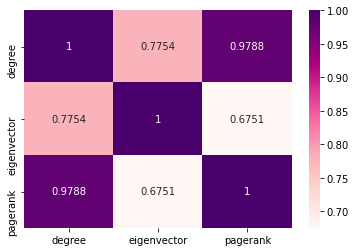

In [191]:
sns.heatmap(centralities_df.corr(method='spearman'), annot=True, fmt='.4g', cmap='RdPu')

#### Task 2.3.1
(ii)
Discuss the similarity between the node rankings according to the different centrality measures and explain why the centrality rankings might differ.

To find the similairty between the node rankings, we can use calculate the correlation between the rankings using the Spearman rank correlation, which measures the strength and direction between two ranked variables.

The node rankings for degree centrality and pagerank centrality are the most similar, with a high correlation score of 97.9%. The node rankings between eigenvector centrality and degree centrality have a lower correlation score of 77.5% and the similairty between the rankings for pagerank and eigenvector centralities are the lowest at 67.5%. 

Perra et al and many other journals have noted that the centrality score of the nodes using pageerank centrality on an undirected graph like the friendship graph in this question is proportional to the number of degrees of the nodes. This is similar to considering the degree centrality of the graph, which gives us the high correlation score between degree centrality and pagerank centrality.

The slight difference between degree and pagerank centrality stems from the fact that pagerank centrality will score a node with a higher ranking if it is directly linked to other nodes which are highly central as well. This implies that the score of a node is high if it is directly linked to nodes with large degrees. However, degree centrality only considers the degree of the node itself. A higher degree indicates a higher score for the node. This results in the slight difference in the rankings.

There is a large difference between the rankings of the nodes observed using eigenvector centrality compared to that of degree centrality, given the lower correlation score. This can be contributed to the way nodes are ranked in both cases. The eigenvector centrality of a node is computed by considering the centralities of its neighbours, and we assign higher centrality to nodes that are connected to highly central nodes. Eigenvector centraliity differs from degree centrality in that a node receiving many links might not necessarily have a high eigenvector centrality score as in degree centraliity, since it might be connected to other nodes of low eigenvector centrality. A node with high eigenvector centrality does not need to be highly linked, it only needs to be directly linked to other important nodes. This results in the larger difference observed between eigenvector centrality rankings and degree centrality rankings.

Since the pagerank centrallity rankings for an undirected graph is similar to the degree centrality rankings, it is expected that there will be a low correlation score between these two rankings, as explained above. 


### 2.3.2 Community detection

Modularity is a cost function that we can use to find the maximallly block-diagonal structure in the adjacency matrix, by counting the edges within blocks as well as between blocks. It attempts to find the clusterings that will have most of the edges within clusters and few edges between clusters. We also consider the null model where every node in the graph is connected at random and use this as a measure of goodness of a partition.

Since modularity is best optimised using a greedy agglomerative algorithm, we can compute the optimal number of communities, $k^*$ and the corresponding partitions of the karate club graph using a networkx module.

In [340]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
# create graph from adjacency matrix
karate_graph = nx.Graph(A)
communities = greedy_modularity_communities(karate_graph)


The optimal number of communities is 3


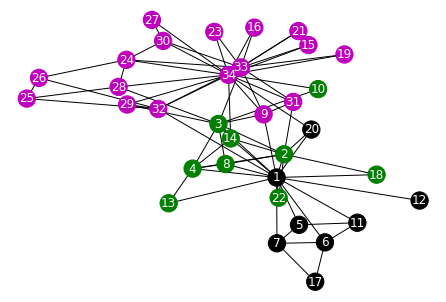

In [743]:
opt_number_of_c = len(communities)
print(f"The optimal number of communities is {opt_number_of_c}")
color_map = [0 for _ in range(N)]
colors = ['m', 'g', 'k']

# assign different colours to different clusters
for k, color in zip(communities, colors):
    ls = list(k)
    for e in ls:
        color_map[e] = color

show_graph(karate_graph, color_map)

#### Task 2.3.2
We take the index of the node as the label of the node, with index starting at 1.

The top 8 most central nodes according to degree and pagerank is as follows:

Ranking| Degree | Pagerank
:--- | :---: | :---:|
 1| 34 | 34
2| 1 | 1
3 | 33 | 33
4 | 3|  3
5 | 2 | 2
6 | 4 | 32
7 | 32 | 4
8 | 24 | 24

4 of the top 8 nodes, (24, 32, 33, 34) are in the first community (coloured as magenta) in the degree centrality method. 3 (2, 3, 4) are in the second community (coloured as green) and one of the top 8 nodes (1) is in the third community (coloured as black).

Similarly, for pagerank centralities, 4 of the top 8 nodes (24, 32, 33, 34) are in the first community, 3 (2, 3, 4) are in the second community and the last node (1) is in the third community.

From the graph above, we can see that the nodes 34, 33 and 32 are the nodes in the first community that are connected to the other communities. 34 is connected to nodes 14 and 10 from the second community and node 20 from the third community, while 33 and 32 is connected to node 3 from the second community. 32 is also connected to node 1 from the third community. Intuitively, these nodes are important since they connect the first community to the other clusters and the rest of the graph, and since we use modularity to obtain the optimal number of communities, we want to minimise the number of edges between clusters, which is why the nodes with edges between clusters have high centrality scores since they are representative samples in the dataset. Node 24, on the other hand, are connected to important nodes like 34 and 33, and hence also has a high centrality score.

In the second community, node 3 is connected to nodes 31, 32, 33 and 9 from community 1, node 2 is connected to node 31 from the first community and nodes 20 and 1 from the third community, and node 4 is connected to node 1 from the third community. All these nodes are nodes from the second cluster that connect to multiple nodes from the other clusters, which would again, make them important nodes.

Lastly, node 1 in the third community is conneected to nodes 22, 2 and 18 from the third community and node 9 from the first community, making it one of the nodes in with top 8 centralities.


### 2.3.3 Comparing Clusterings

We can compare how similar the clusterings are with respect to each other by creating a count matrix that matches the number of coincident elements in each cluster of the two clusterings. A summary measure is compiled as a quality of overlap of elements across clusters. The Adjusted Rand Index is a method to compare different clusters with each other. 

We can thus compute the adjusted rand index using the formula below:

$$
A R I=\frac{\sum_{i j}\left(\begin{array}{c}
n_{i j} \\
2
\end{array}\right)-\left[\sum_{i}\left(\begin{array}{c}
a_{i} \\
2
\end{array}\right) \sum_{j}\left(\begin{array}{c}
b_{j} \\
2
\end{array}\right)\right] /\left(\begin{array}{c}
n \\
2
\end{array}\right)}{\frac{1}{2}\left[\sum_{i}\left(\begin{array}{c}
a_{i} \\
2
\end{array}\right)+\sum_{j}\left(\begin{array}{c}
b_{j} \\
2
\end{array}\right)\right]-\left[\sum_{i}\left(\begin{array}{c}
a_{i} \\
2
\end{array}\right) \sum_{j}\left(\begin{array}{c}
b_{j} \\
2
\end{array}\right)\right] /\left(\begin{array}{c}
n \\
2
\end{array}\right)}
$$

where i is the row number, j is the column number, a is the row sum, b is the column sum and $n_{ij}$ is the number of data points in common between $X_i$ and $Y_j$, and n is the number of data points

In [597]:
ROW_SUM = -1
COL_SUM = -1

# form the contigency table for the two clusterings
def gen_count_mat(labels_1, labels_2):
    data = {'cluster 1': labels_1, 'cluster 2': labels_2} 
    df = pd.DataFrame(data, columns=['cluster 1', 'cluster 2'])
    # calculate frequencies of objects in common betwen the clusters
    count_mat = pd.crosstab(df['cluster 1'], df['cluster 2']) 

    # add row sum and column sum to the dataframe
    count_mat["ROW_SUM"] = count_mat.sum(axis=1)
    count_mat = count_mat.append(count_mat.sum(axis=0), ignore_index=True)

    return np.array(count_mat)

# compute the ari score given labellings of two different clusters
def compute_ari(labels_1, labels_2):
    count_matrix = gen_count_mat(labels_1, labels_2)
    rows = len(np.unique(labels_1))
    cols = len(np.unique(labels_2))

    # compute combinatorial sum for (ai, 2) and (bi, 2) respectively
    a_comb_sum = sum([math.comb(a_i, 2) for a_i in count_matrix[:rows, -1]])
    b_comb_sum = sum([math.comb(b_j, 2) for b_j in count_matrix[COL_SUM, :cols]])
    n = A.shape[0]

    # calculate sum of math.comb(nij, 2)
    t1 = 0
    for i in range(rows):
        for j in range(cols):
            nij_comb = math.comb(count_matrix[i, j], 2)
            t1 += nij_comb
    
    # calculate the second term in numerator
    t2 = a_comb_sum * b_comb_sum / math.comb(n, 2)

    numer = t1 - t2
    denom = (a_comb_sum + b_comb_sum) / 2 - t2
    return numer / denom

             

In [598]:

community_labels = np.zeros(A.shape[0])
labels = list(range(3))

# assign labels to clusters in optimal k*
for k, label in zip(communities, labels):
    ls = list(k)
    for e in ls:
        community_labels[e] = label

cm = gen_count_mat(community_labels, labels_for_optimal_ch_clustering)
ari = compute_ari(community_labels, labels_for_optimal_ch_clustering)

In [744]:
print(f"The ari value for the optimal clusterings obtained using the CH score and the greedy modularity maximisation algorithm is: {ari}")


The ari value for the optimal clusterings obtained using the CH score and the greedy modularity maximisation algorithm is: -0.031487014479429976


To compare these clusterings obtained in 2.1.2 and 2.3.2 to the ground truth split given, we load the split using numpy and compute the ARI score between both these clusterings and the ground truth clustering. 

In [607]:
# load ground truth labels using pandas and convert into numpy array for ease of computation
ground_truth_labels = pd.read_csv("ground_truth_karate_club.csv").iloc[:, 1:]
ground_truth_labels = np.array(ground_truth).flatten()
# get unique ground truth labels
unique_ground_truth_labels = np.unique(ground_truth)
label_count = 0

# change ground truth labels to integers instead of string
for label in unique_ground_truth_labels:
    ground_truth[ground_truth == label] = label_count
    label_count += 1

ari_of_ch_cluster_and_ground_truth = compute_ari(ground_truth_labels, labels_for_optimal_ch_clustering)
ari_of_community_and_ground_truth = compute_ari(ground_truth_labels, community_labels)

In [746]:
print(f"The ari value for the optimal clusterings obtained using the CH score and the ground truth clustering is:")
ari_of_ch_cluster_and_ground_truth

The ari value for the optimal clusterings obtained using the CH score and the ground truth clustering is:


0.0012970168612192327

In [747]:
print(f"The ari value for the optimal clusterings obtained using the greedy modularity maximisation algorithm and the ground truth clustering is:")
ari_of_community_and_ground_truth

The ari value for the optimal clusterings obtained using the greedy modularity maximisation algorithm and the ground truth clustering is:


0.5684394071490846

#### Task 2.3.3 Comparing the optimal clusterings using ARI


Clusters | CH Score  | Greedy Modularity | Ground Truth
:--: | :--: | :--:
**CH Score**  | -| -0.0314 |  0.568
**Greedy Modularity**  | | -| 0.001


The Adjusted Rand Index gives us a score of the similarity or overlap of the two different clusterings obtained, adjusted for the chance of random overlaps, where data points are randomly assigned to different clusters. A high positive value of ARI indicates that the two clusters are very similar and concurs with each other. An ARI value of 0 indicates that the clusterings are no better than the chances of overlap of a random set. A negative ARI value indicates that the amount of overlap is less than what is expected from a random result, and implies that these clusterings might be complementary to some extent. 

The ARI for the optimal clusterings obtained using the CH score and the greedy modularity maximisation algorithm is: -0.0314, which is a small negative value close to 0. We have a result that is quite close to randomness and thus, we cannot say that the two clusters are similar. 

On the other hand, there is a high ari value for the optimal clusterings obtained using the greedy modularity maximisation algorithm and the ground truth clustering, of 0.568. This implies that the two clusterings are similar. 
The clustering obtained from the CH score and the ground truth clustering is not similar since we also get a small positive ARI value of 0.001 close to zero, implying that this result is close to randomness.